In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [20]:
import matplotlib as mpl

# Configuración de LaTeX para matplotlib
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "xelatex",        # change this if using xetex or lautex
    "text.usetex": False,                # use LaTeX to write all text
    "font.family": "sans-serif",
    # "font.serif": [],
    "font.sans-serif": ["DejaVu Sans"], # specify the sans-serif font
    "font.monospace": [],
    "axes.labelsize": 8,               # LaTeX default is 10pt font.
    "font.size": 0,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    # "figure.figsize": (3.15, 2.17),     # default fig size of 0.9 textwidth
    "pgf.preamble": r'\usepackage{amsmath},\usepackage{amsthm},\usepackage{amssymb},\usepackage{mathspec},\renewcommand{\familydefault}{\sfdefault},\usepackage[italic]{mathastext}'
    }
mpl.rcParams.update(pgf_with_latex)

In [121]:


# ==== Datos ====
x_min, x_max = -2, 2
x = np.linspace(x_min, x_max, 400)
f = x**3 + x**2 - x - 1
# Gaussian function centered at x=0 
#f = np.exp(-((x - 0)**2) / 0.5)

x_tensor_full = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
f_tensor_full = torch.tensor(f, dtype=torch.float32).unsqueeze(1)

# ==== Modelo ====
class FixedBreakReLU(nn.Module):
    def __init__(self, fixed_break, activate_left=False, y_offset=0.0):
        super().__init__()
        self.register_buffer("x_star", torch.tensor([[fixed_break]], dtype=torch.float32))
        self.w = nn.Parameter(torch.tensor([[0.1]], dtype=torch.float32))
        self.y_offset = nn.Parameter(torch.tensor([[y_offset]], dtype=torch.float32))
        self.activate_left = activate_left

    def forward(self, x):
        if self.activate_left:
            z = torch.relu(self.x_star - x.T)
        else:
            z = torch.relu(x.T - self.x_star)
        out = (self.w.T @ z).T + self.y_offset
        return out, z

# ==== Lista de tramos automática con número definido de segmentos ====
num_segments = 8  # <-- define aquí cuántos segmentos quieres
segments = []

# Calcular tamaño de cada tramo
step = (x_max - x_min) / num_segments
curr = x_min
for i in range(num_segments):
    segments.append((curr, min(curr + step, x_max)))
    curr += step

print("Tramos generados:", segments)

# ==== Entrenamiento por tramo ====
y_accum = np.zeros_like(x)
prev_slope_accum = 0.0
all_contribs = []        # guardar contribuciones individuales
partial_accums = []      # guardar acumulados parciales

prev_y_at_right = 0.0

for i, (seg_left, seg_right) in enumerate(segments):
    mask_local = (x >= seg_left) & (x <= seg_right)
    x_local = x[mask_local]
    f_local = f[mask_local]
    x_tensor_local = torch.tensor(x_local, dtype=torch.float32).unsqueeze(1)
    f_tensor_local = torch.tensor(f_local, dtype=torch.float32).unsqueeze(1)

    offset_start = y_accum[np.argmin(np.abs(x - seg_left))]

    # ==== Configuración del break y offset ====
    if i == 0:
        fixed_break = seg_left
        activate_left = False
        model = FixedBreakReLU(fixed_break=fixed_break, activate_left=activate_left, y_offset=0.0)
        model.y_offset = nn.Parameter(torch.tensor([[0.0]], dtype=torch.float32))
        optimizer = optim.Adam([model.w, model.y_offset], lr=0.05)
    else:
        fixed_break = seg_left
        activate_left = False
        model = FixedBreakReLU(fixed_break=fixed_break, activate_left=activate_left, y_offset=offset_start)
        optimizer = optim.Adam([model.w], lr=0.05)

    loss_fn = nn.MSELoss()

    # ==== Entrenamiento ====
    for epoch in range(3000):
        optimizer.zero_grad()
        out_local, _ = model(x_tensor_local)
        target_corr = f_tensor_local - prev_slope_accum * (x_tensor_local - seg_left)
        loss = loss_fn(out_local, target_corr)
        loss.backward()
        optimizer.step()

    # ==== Evaluación ====
    with torch.no_grad():
        out_full, z_full = model(x_tensor_full)
        contrib = (model.w * z_full).squeeze().numpy()
        if i == 0:
            contrib += model.y_offset.item()

        all_contribs.append(contrib.copy())
        y_accum += contrib
        partial_accums.append(y_accum.copy())

        prev_slope_accum += model.w.item()
        prev_y_at_right = y_accum[np.argmin(np.abs(x - seg_right))]

  

Tramos generados: [(-2, -1.5), (-1.5, -1.0), (-1.0, -0.5), (-0.5, 0.0), (0.0, 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0)]


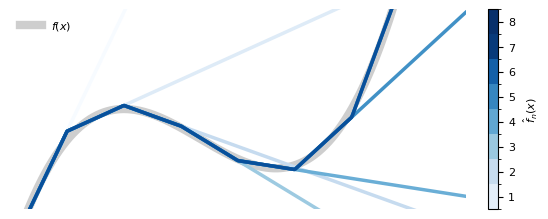

In [129]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# ==== Graficar todas las sumas parciales acumuladas ====
cmap_base = plt.get_cmap('Blues')
num_segments = len(partial_accums)

# Discretize the colormap into N levels
colors = [cmap_base(i / (num_segments )) for i in range(num_segments)]
cmap_discrete = mpl.colors.ListedColormap(colors)

fig, ax = plt.subplots(figsize=(5.5, 2.1), constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.10, h_pad=0.05)
# ==== Central axes ====
# ax.spines['top'].set_color('none')
# ax.spines['right'].set_color('none')
# ax.spines['bottom'].set_position('zero')
# ax.spines['left'].set_position('zero')
# ax.spines['bottom'].set_linewidth(1.2)
# ax.spines['left'].set_linewidth(1.2)

ax.plot(x, f, '-', color="#CECECE", linewidth=6, label=r'$f(x)$')

for i, partial in enumerate(partial_accums):
    ax.plot(x, partial, color=colors[i], lw=2.5, alpha=1.0)

#ax.set_xlabel("$x$", labelpad=10)
#ax.set_ylabel(r"$f(x)$ and $\hat{f}_{n}(x)$")
# ax.set_xticks(np.arange(x_min, x_max + 0.1, 1.0))
# ax.set_yticks(np.arange(-2, 2 + 0.1, 1.0))
ax.set_ylim([-2.0, 2.0])
ax.set_xlim([x_min, x_max])
ax.axis('off')

# ==== Colorbar ====
# Discretize the colormap into N levels
colors = [cmap_base(0.1 + 1.0 * i / (num_segments - 1)) for i in range(num_segments)]
cmap_discrete = mpl.colors.ListedColormap(colors)

# Definir límites y normalización
bounds = np.linspace(0, num_segments + 0, num_segments + 1) +0.5 # de 0 a N+1
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=num_segments + 1)

# Crear el objeto de colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap_discrete, norm=norm)
sm.set_array([])

# Mostrar ticks de 0 a num_segments + 1 (incluye los extremos)
cbar = fig.colorbar(sm, ax=ax, ticks=np.arange(0, num_segments + 2))
cbar.set_label(r"$\hat{f}_{n}(x)$")

# ==== Legend and layout ====
ax.legend(loc='upper left', fontsize=8, frameon=False)
 
plt.savefig("universal_approximation_example_plot.pdf", dpi=300, bbox_inches='tight')
plt.savefig("universal_approximation_example_plot.svg", dpi=300, bbox_inches='tight')
plt.show()

